In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from gensim.models import word2vec
import xgboost as xgb
import matplotlib.pyplot as plt

# from keras.models import Sequential
# from keras.utils.np_utils import to_categorical
# from keras.layers import Dropout, Dense, Activation
# from keras.layers import BatchNormalization

from utils import preprocess
np.random.seed(1234)

In [2]:
num_split = 5

In [3]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [4]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')

In [5]:
vec.most_similar(positive=['love'])

[('loved', 0.8400787115097046),
 ('lovelier', 0.8375217914581299),
 ('lover', 0.8341007828712463),
 ('loves', 0.8205721378326416),
 ('clove', 0.8196173906326294),
 ('loveliest', 0.8140965700149536),
 ("beloved's", 0.7933589220046997),
 ("lover's", 0.7773091197013855),
 ('jove', 0.7757792472839355),
 ('glove', 0.7705390453338623)]

In [6]:
vec.most_similar(positive=['the'])

[('theft', 0.8367539048194885),
 ("amalthea's", 0.8247981071472168),
 ('therefrom', 0.8049554824829102),
 ("'υπνος", 0.7993500232696533),
 ('cn', 0.7949093580245972),
 ('xiv', 0.7938920259475708),
 ('oxydracae', 0.786963701248169),
 ('cimabué', 0.7844108939170837),
 ('ottawa', 0.7829217910766602),
 ("azrael's", 0.7828168272972107)]

In [7]:
def create_vector(vec):
    n = vec.vector_size
    x = np.zeros((len(df), n))
    for i, doc in enumerate(df.text):
        doc_vec = np.zeros(n)
        words = preprocess(doc).lower().split()
        num_words = 0
        for w in words:
            if w in vec.vocab:
                doc_vec += vec[w]
                num_words += 1
        doc_vec /= num_words
        x[i] = doc_vec

    x_test = np.zeros((len(df_test), n))
    for i, doc in enumerate(df_test.text):
        doc_vec = np.zeros(n)
        words = preprocess(doc).lower().split()
        num_words = 0
        for w in words:
            if w in vec.vocab:
                doc_vec += vec[w]
                num_words += 1
        doc_vec /= num_words
        x_test[i] = doc_vec
    return x, x_test

In [8]:
def logistic(x, x_test, seed=7):
    num_split = 5
    kf = KFold(n_splits=num_split, random_state=seed, shuffle=True)
    loss = 0.

    predict_prob_features = np.zeros((len(df), 3))
    predict_prob_features_test = np.zeros((len(df_test), 3))

    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = LogisticRegression()
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)
        predict_prob_features_test += model.predict_proba(x_test)
        predict_prob_features[val_index] = y_pred
        loss += log_loss(y_pred=y_pred, y_true=y_val)

    print(loss/5)
    return predict_prob_features, predict_prob_features_test

In [9]:
#  ./fasttext skipgram -input ../data/fasttext-inputs.txt -output model -minCount 1  -neg 15 -ws 10 -epoch 7
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')
x, x_test = create_vector(vec)

In [10]:
predict_prob_features, predict_prob_features_test = logistic(x, x_test)

0.521292042282


In [11]:
for a, c in author2class.items():
    df['{}_fasttext_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [12]:
# vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/skip20_min2_neg15_epoch_7_ws_20.vec') # 0.527408070746
# x, x_test = create_vector(vec)
# predict_prob_features, predict_prob_features_test = logistic(x, x_test, 7)

In [13]:
# for a, c in author2class.items():
#     df['{}_fasttext_low_dim_logi'.format(a)] = predict_prob_features[:, c]
#     df_test['{}_fasttext_low_dim_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [14]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/cbow100_min1_neg15_epoch_7_ws_10.vec') # 0.527408070746
x, x_test = create_vector(vec)
predict_prob_features, predict_prob_features_test = logistic(x, x_test, 7)

0.802415782991


In [15]:
for a, c in author2class.items():
    df['{}_fasttext_cbow_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_cbow_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [16]:
def vectorizer_feature(vectorizer, seed=8):
    kf = KFold(n_splits=num_split, random_state=seed, shuffle=True)
    loss = 0.

    predict_prob_features = np.zeros((len(df), 3))
    predict_prob_features_test = np.zeros((len(df_test), 3))

    for train_index, val_index in kf.split(text):
        print(len(train_index), len(val_index))
        text_train, text_val = text[train_index], text[val_index]
        y_train, y_val = y[train_index], y[val_index]

        x_train = vectorizer.fit_transform(text_train)
        x_val = vectorizer.transform(text_val)

        model = MultinomialNB()
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)

        predict_prob_features[val_index] = y_pred
        loss += log_loss(y_pred=y_pred, y_true=y_val)

        predict_prob_features_test += model.predict_proba(vectorizer.transform(text_test))

    print(loss/5)
    return predict_prob_features, predict_prob_features_test


In [17]:
vectorizer = TfidfVectorizer(ngram_range=(4, 5), analyzer='char')

In [18]:
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 8)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.604632133935


In [19]:
for a, c in author2class.items():
    df['{}_char_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 7)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.706003820852


In [21]:
for a, c in author2class.items():
    df['{}_word_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='word')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 7)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.868949779387


In [23]:
for a, c in author2class.items():
    df['{}_word_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [24]:
vectorizer = CountVectorizer(ngram_range=(2, 4), analyzer='char')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 5)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
2.50491390234


In [25]:
for a, c in author2class.items():
    df['{}_char_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [26]:
# counter = {name : defaultdict(int) for name in set(df.author)}
# for (text, author) in zip(df.text, df.author):
#     text = text.replace(' ', '')
#     for c in text:
#         counter[author][c] += 1
    
# chars = set()
# for v in counter.values():
#     chars |= v.keys()
    
# names = [author for author in counter.keys()]
# special_latters = set()

# for c in chars:    
#     special_latters.add(c)
# special_latters = special_latters - 

In [27]:
normal_latters = set(string.ascii_uppercase) | set(string.ascii_lowercase) | set(',.:;"\'? ')

In [28]:
df['num_chars'] = np.array([len(t) for t in df.text])
df_test['num_chars'] = np.array([len(t) for t in df_test.text])

df['num_words'] = np.array([len(t.split()) for t in df.text])
df_test['num_words'] = np.array([len(t.split()) for t in df_test.text])

df['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df.text])
df_test['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df_test.text])

special = ',' # ',.:;"\'?'
for c in special:
    df['num_'+c] = np.array([t.count(c) for t in df.text])
    df_test['num_'+c] = np.array([t.count(c) for t in df_test.text])


In [29]:
# num_special_chars = []
# for t in df.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df['num_special_chars'] = np.array(num_special_chars)

# num_special_chars = []
# for t in df_test.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df_test['num_special_chars'] = np.array(num_special_chars)


In [30]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

In [31]:
# kf = model_selection.KFold(n_splits=num_split, shuffle=True, random_state=2017)
# xgb_model = xgb.XGBClassifier()

In [32]:
df.keys()

Index(['EAP_fasttext_logi', 'HPL_fasttext_logi', 'MWS_fasttext_logi',
       'EAP_fasttext_cbow_logi', 'HPL_fasttext_cbow_logi',
       'MWS_fasttext_cbow_logi', 'EAP_char_tfidf_NB', 'HPL_char_tfidf_NB',
       'MWS_char_tfidf_NB', 'EAP_word_tfidf_NB', 'HPL_word_tfidf_NB',
       'MWS_word_tfidf_NB', 'EAP_word_count_NB', 'HPL_word_count_NB',
       'MWS_word_count_NB', 'EAP_char_count_NB', 'HPL_char_count_NB',
       'MWS_char_count_NB', 'num_chars', 'num_words', 'average_num_chars',
       'num_,'],
      dtype='object')

In [33]:
# df.drop('EAP_fasttext_logi', axis=1, inplace=True)
# df.drop('HPL_fasttext_logi', axis=1, inplace=True)
# df.drop('MWS_fasttext_low_dim_logi', axis=1, inplace=True)

In [40]:
df.tail()

,EAP_fasttext_logi,HPL_fasttext_logi,MWS_fasttext_logi,EAP_fasttext_cbow_logi,HPL_fasttext_cbow_logi,MWS_fasttext_cbow_logi,EAP_char_tfidf_NB,HPL_char_tfidf_NB,MWS_char_tfidf_NB,EAP_word_tfidf_NB,...,EAP_word_count_NB,HPL_word_count_NB,MWS_word_count_NB,EAP_char_count_NB,HPL_char_count_NB,MWS_char_count_NB,num_chars,num_words,average_num_chars,"num_,"
19574,0.502453,0.407642,0.089905,0.402772,0.478072,0.119155,0.646308,0.178946,0.174746,0.545433,...,0.821004,1.788949e-01,1.014361e-04,4.385717e-04,1.418646e-01,8.576969e-01,108,20,4.450000,2
19575,0.648131,0.008790,0.343079,0.654535,0.264869,0.080597,0.668146,0.075501,0.256353,0.530387,...,0.960863,3.663572e-04,3.877103e-02,3.393561e-01,2.354951e-04,6.604084e-01,55,10,4.600000,0
19576,0.974873,0.021578,0.003548,0.663832,0.291408,0.044760,0.871611,0.061914,0.066475,0.854690,...,1.000000,9.020228e-12,1.238931e-09,1.000000e+00,5.040300e-13,5.375959e-13,68,13,4.307692,1
19577,0.693803,0.113793,0.192404,0.759826,0.224728,0.015446,0.746419,0.167788,0.085793,0.568534,...,0.957735,4.218386e-02,8.136838e-05,9.999985e-01,1.540827e-06,8.148653e-11,74,15,4.000000,1
19578,0.205407,0.672515,0.122078,0.355702,0.398203,0.246095,0.616580,0.212289,0.171131,0.576162,...,0.959739,4.016009e-02,1.007295e-04,1.042207e-08,9.999672e-01,3.275839e-05,109,22,4.000000,1


In [35]:
df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)

In [36]:
scale_targets = ['num_words', 'num_chars', 'average_num_chars'] + ['num_{}'.format(c) for c in special]

In [37]:
scale_targets

['num_words', 'num_chars', 'average_num_chars', 'num_,']

In [38]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1 #01
param['max_depth'] = 3
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3
param['seed'] = 7
num_rounds = 6000

cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
results = np.zeros((len(df_test), 3))
for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    print(len(x_train), len(x_val))
    

    for k in scale_targets:
        scaler = MinMaxScaler()
        x_train[k] = scaler.fit_transform(x_train[k].values.reshape(len(x_train[k]), 1)).reshape(-1)
        x_val[k] = scaler.transform(x_val[k].values.reshape(len(x_val[k]), -1)).reshape(-1)
        df_test[k] = scaler.transform(df_test[k].values.reshape(len(df_test[k]), -1)).reshape(-1)

    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=50)
    

    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


15663 3916
[0]	train-mlogloss:1.01364	test-mlogloss:1.01381
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.


/Users/nzw/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[50]	train-mlogloss:0.347325	test-mlogloss:0.354866
[100]	train-mlogloss:0.312585	test-mlogloss:0.335807
[150]	train-mlogloss:0.2923	test-mlogloss:0.328767
[200]	train-mlogloss:0.277036	test-mlogloss:0.325645
[250]	train-mlogloss:0.264385	test-mlogloss:0.325268
[300]	train-mlogloss:0.252799	test-mlogloss:0.32483
[350]	train-mlogloss:0.24263	test-mlogloss:0.32472
[400]	train-mlogloss:0.232881	test-mlogloss:0.325023
[450]	train-mlogloss:0.223726	test-mlogloss:0.326076
Stopping. Best iteration:
[314]	train-mlogloss:0.249746	test-mlogloss:0.324397

15663 3916
[0]	train-mlogloss:1.01357	test-mlogloss:1.01407
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[50]	train-mlogloss:0.345182	test-mlogloss:0.362931
[100]	train-mlogloss:0.310107	test-mlogloss:0.342541
[150]	train-mlogloss:0.290357	test-mlogloss:0.336109
[200]	train-mlogloss:0.275043	test-mlogloss:0.333173
[250]	train-mlogloss:0.262

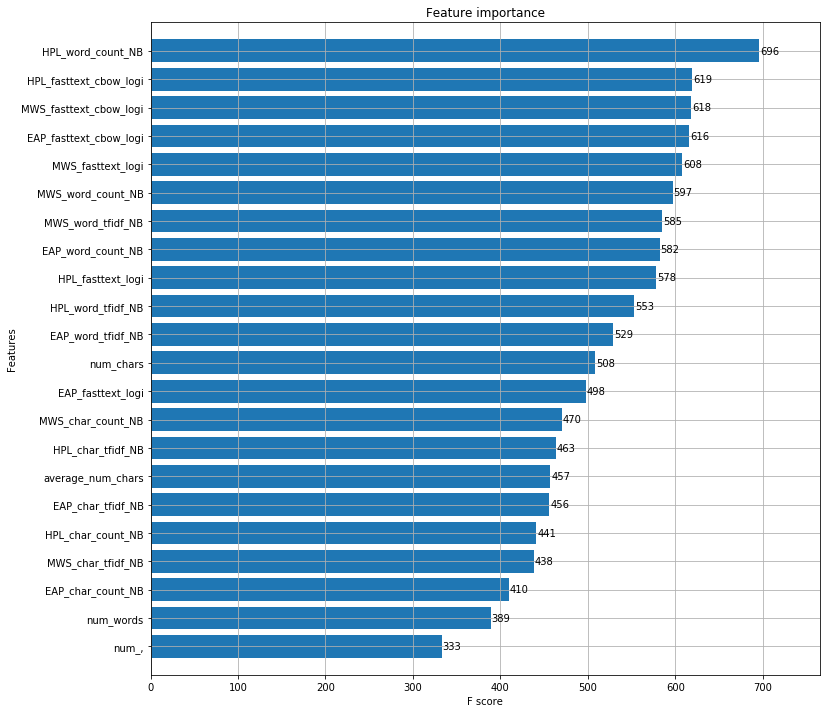

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [43]:
submission_df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    submission_df[a] = results[:, i]/5

with open('./results/first_xgboost_cbow.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in submission_df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')